# Relearning Policy with Supervised Learning

In [21]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import json

import tensorflow as tf
import gym

from spinup.algos.vd3_delayed_dropout import core
from spinup.algos.vd3_delayed_dropout.core import get_vars
from spinup.algos.vd3_delayed_dropout.investigate_uncertainty import DropoutUncertaintyModule
from spinup.utils.run_utils import setup_logger_kwargs

## Load Data

In [2]:

# Load configuration
config_file_path = r"C:\Users\pc-admin\Github Repos\spinningup\data\2019-04-03_ud3_test_experience_saving\2019-04-03_22-43-40-ud3_test_experience_saving_s3\config.json"
with open(config_file_path) as config_file:
    config = json.load(config_file)

# Load experiences
experience_file_path = r"C:\Users\pc-admin\Github Repos\spinningup\data\2019-04-04_ud3_test_experience_saving\2019-04-04_00-17-28-ud3_test_experience_saving_s3\experiences.txt"
experience_df = pd.read_csv(experience_file_path, sep='\t')

# Load uncertainty change record
uncertainty_file_path = r"C:\Users\pc-admin\Github Repos\spinningup\data\2019-04-04_ud3_test_experience_saving\2019-04-04_00-17-28-ud3_test_experience_saving_s3\uncertainty.txt"
uncertainty_df = pd.read_csv(uncertainty_file_path,  sep='\t')

# Load sampled observations
sample_obs_file_path = r"C:\Users\pc-admin\Github Repos\spinningup\data\2019-04-04_ud3_test_experience_saving\2019-04-04_00-17-28-ud3_test_experience_saving_s3\sample_observation.txt"
sample_obs_df = pd.read_csv(sample_obs_file_path,  sep='\t')

# Load epoch record
progress_file_path = r"C:\Users\pc-admin\Github Repos\spinningup\data\2019-04-04_ud3_test_experience_saving\2019-04-04_00-17-28-ud3_test_experience_saving_s3\progress.txt"
progress_df = pd.read_csv(progress_file_path,  sep='\t')


### Restore hyper-parameters

In [3]:
config

{'a_std_clip_max': 1.0,
 'a_std_clip_min': 0.1,
 'a_var_clip_max': 1.0,
 'a_var_clip_min': 0.1,
 'ac_kwargs': {'hidden_sizes': [300, 300]},
 'act_noise': 0.1,
 'action_choose_method': 'gaussian_sample_with_scaling_and_lower_bound',
 'actor_critic': 'mlp_actor_critic',
 'batch_size': 100,
 'concentration_factor': 0.1,
 'dropout_rate': 0.1,
 'env_fn': '<function <lambda> at 0x000001E78D25C268>',
 'epochs': 200,
 'exp_name': 'ud3_test_experience_saving',
 'gamma': 0.99,
 'logger': {'<spinup.utils.logx.EpochLogger object at 0x000001E78D25DB00>': {'epoch_dict': {},
   'exp_name': 'ud3_test_experience_saving',
   'first_row': True,
   'log_current_row': {},
   'log_headers': [],
   'output_dir': 'c:\\users\\pc-admin\\github repos\\spinningup\\data\\2019-04-03_ud3_test_experience_saving\\2019-04-03_22-43-40-ud3_test_experience_saving_s3',
   'output_file': {"<_io.TextIOWrapper name='c:\\\\users\\\\pc-admin\\\\github repos\\\\spinningup\\\\data\\\\2019-04-03_ud3_test_experience_saving\\\\2019-

In [22]:
seed = config['seed']
n_post_action = config['n_post_action']
n_post_q = config['n_post_q']
batch_size = config['batch_size']
steps_per_epoch = config['steps_per_epoch']
epochs = config['epochs']

replay_size = config['replay_size']
max_ep_len = config['max_ep_len']

ac_kwargs = config['ac_kwargs']
dropout_rate=config['dropout_rate']
noise_clip = config['noise_clip']

gamma = config['gamma']
pi_lr = config['pi_lr']
q_lr = config['q_lr']
polyak = config['polyak']

target_policy_smooth = config['target_policy_smooth']
target_noise = config['target_noise']

logger_kwargs = setup_logger_kwargs(config['logger_kwargs']['exp_name'], seed, datestamp=True)

In [23]:
logger_kwargs

{'output_dir': 'c:\\users\\pc-admin\\github repos\\spinningup\\data\\2019-04-12_ud3_test_experience_saving\\2019-04-12_11-05-56-ud3_test_experience_saving_s3',
 'exp_name': 'ud3_test_experience_saving'}

In [8]:
obs_dim = 17
act_dim = 6


### Put experience into ReplayBuffer

In [9]:
class RelearningExperienceBuffer:
    """
    A simple FIFO experience replay buffer for TD3 agents.
    """

    def __init__(self, obs_dim, act_dim, experience_df):
        
        self.size = experience_df.shape[0]
        self.obs1_buf = experience_df.iloc[:,2:2+obs_dim].copy().values
        self.acts_buf = experience_df.iloc[:,2+obs_dim:2+obs_dim+act_dim].copy().values
        self.rews_buf = np.squeeze(experience_df.iloc[:,2+obs_dim+act_dim:2+obs_dim+act_dim+1].copy().values)
        self.obs2_buf = experience_df.iloc[:,2+obs_dim+act_dim+1:2+obs_dim+act_dim+1+obs_dim].copy().values
        self.done_buf = np.squeeze(experience_df.iloc[:,2+obs_dim+act_dim+1+obs_dim:2+obs_dim+act_dim+1+obs_dim+1].copy().values)
        
        self.q_targ_buf = np.zeros(self.size, dtype=np.float32)
        
        # Sort experience buffer in descending order
        sort_index = np.argsort(-self.rews_buf)
        self.obs1_buf_sorted = self.obs1_buf[sort_index].copy()
        self.acts_buf_sorted = self.acts_buf[sort_index].copy()
        self.rews_buf_sorted = self.rews_buf[sort_index].copy()
        self.obs2_buf_sorted = self.obs2_buf[sort_index].copy()
        self.done_buf_sorted = self.done_buf[sort_index].copy()
        
       
    def sample_batch_sorted(self, batch_size=32, top=100000):
        """Sample batch from sorted experiences."""
        # TODO: sorted by reward but we also need to keep diversity of states
        # Should be for each unique state select (s,a) with high rewward
        idxs = np.random.randint(0, top, size=batch_size)
        return dict(obs1=self.obs1_buf_sorted[idxs],
                    obs2=self.obs2_buf_sorted[idxs],
                    acts=self.acts_buf_sorted[idxs],
                    rews=self.rews_buf_sorted[idxs],
                    done=self.done_buf_sorted[idxs])
                
    def sample_batch(self, batch_size=32, start=None, end=None):
        if start is None and end is None:
            idxs = np.random.randint(0, self.size, size=batch_size)
        elif start is None and end is not None:
            idxs = np.random.randint(0, end, size=batch_size)
        elif start is not None and end is None:
            idxs = np.random.randint(start, self.size, size=batch_size)
        elif start is not None and end is not None:
            idxs = np.random.randint(start, end, size=batch_size)
        else:
            raise ValueError('Error in sample_batch!')
        return dict(obs1=self.obs1_buf[idxs],
                    obs2=self.obs2_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs],
                    q_targ=self.q_targ_buf[idxs])
    
    def sample_batch_rollout(self, batch_size=32):
        idxs = np.random.randint(0, self.size-self.max_ep_len, size=batch_size)
        return dict(obs1=self.obs1_buf[idxs],
                    obs2=self.obs2_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs],
                    q_targ=self.q_targ_buf[idxs])
    
#     def generate_target_q(self):
#         ### Generate true Q(s,a) from experience trojectory
#         # No rollout for last episode
#         for i in range(self.size-self.max_ep_len):
#             o1 = self.obs1_buf[i]
#             a = self.acts_buf[i]
#             r = self.rews_buf[i]
#             o2 = self.obs2_buf[i]
#             d = self.done_buf[i]
#             q_targ_backup = 0
#             for rollout_i in range(i, i+self.max_ep_len):
#                 q_targ_backup += self.rews_buf[rollout_i]
#                 if self.done_buf[rollout_i]:
#                     break
#             self.q_targ_buf[i] = q_targ_backup
    
replay_buffer = RelearningExperienceBuffer(obs_dim=obs_dim, act_dim=act_dim, experience_df=experience_df)



# replay_buffer.generate_target_q()

### Histgram show distribution of observations in sorted and unsorted replay buffer

<IPython.core.display.Javascript object>


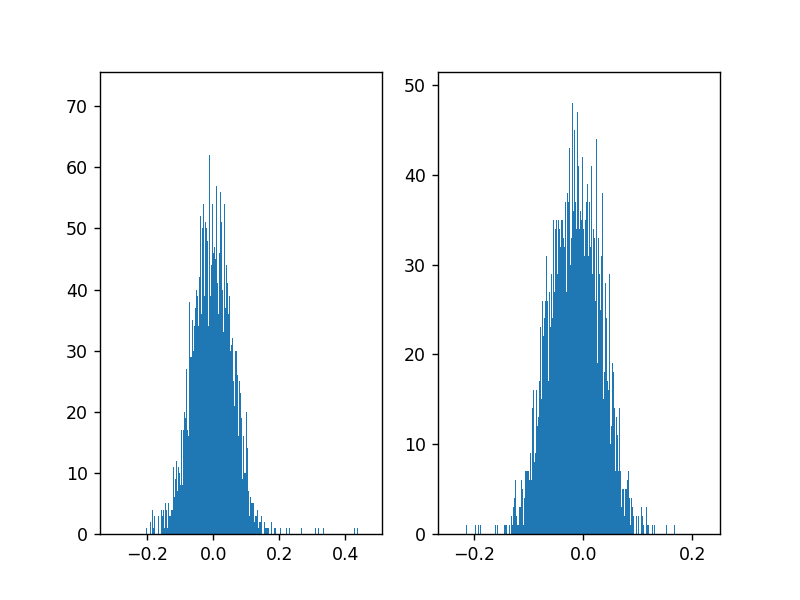

<IPython.core.display.Javascript object>


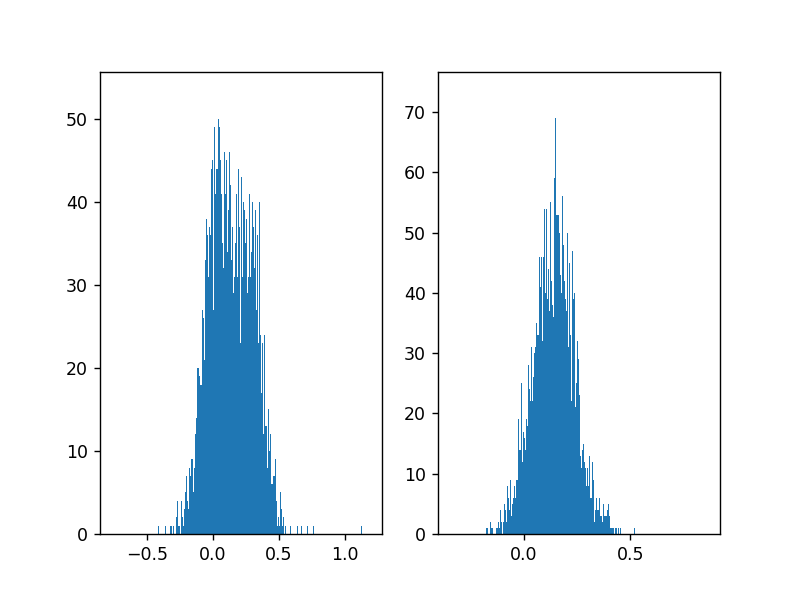

<IPython.core.display.Javascript object>


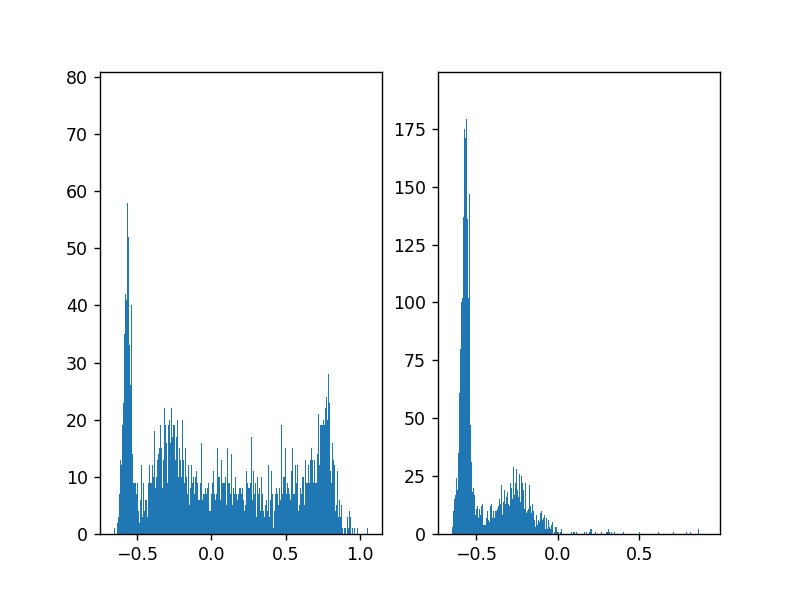

<IPython.core.display.Javascript object>


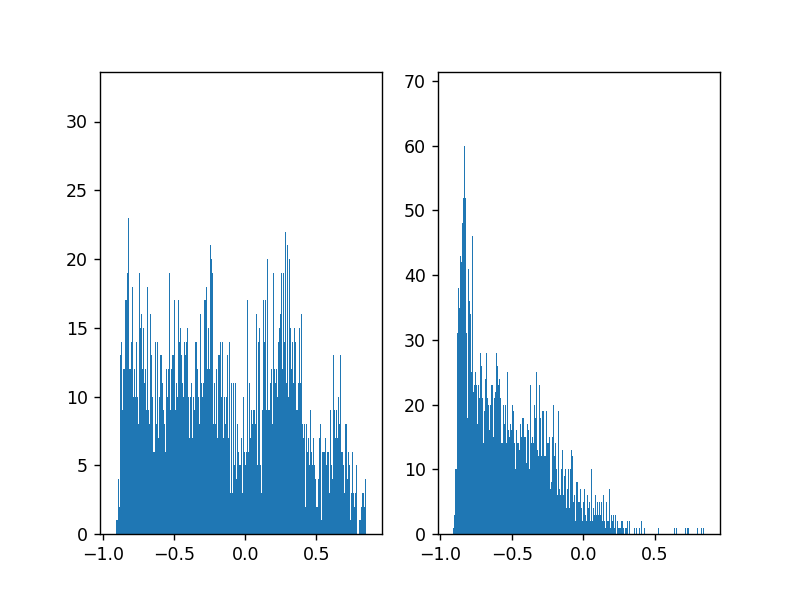

<IPython.core.display.Javascript object>


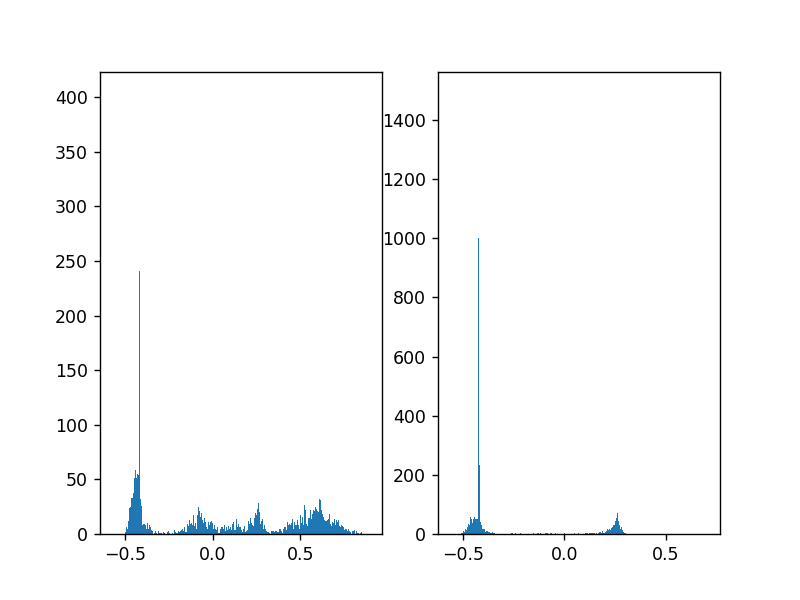

<IPython.core.display.Javascript object>


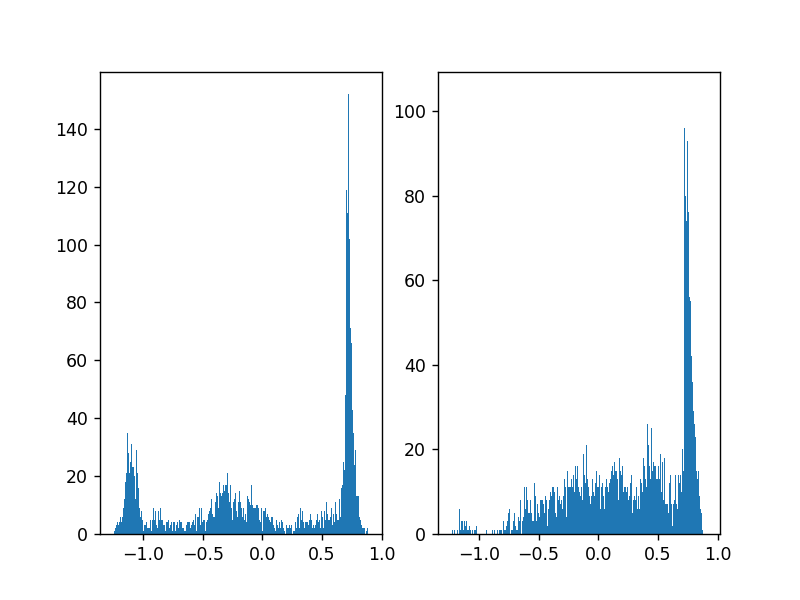

<IPython.core.display.Javascript object>


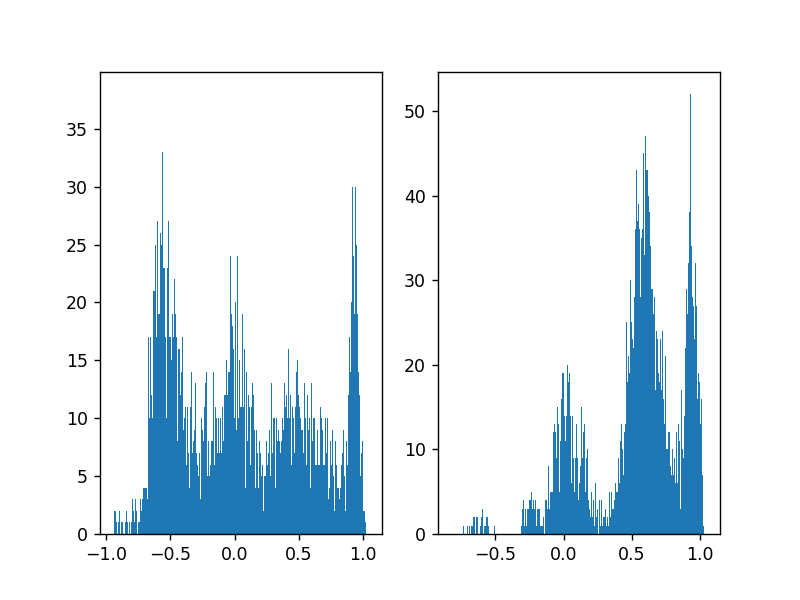

<IPython.core.display.Javascript object>


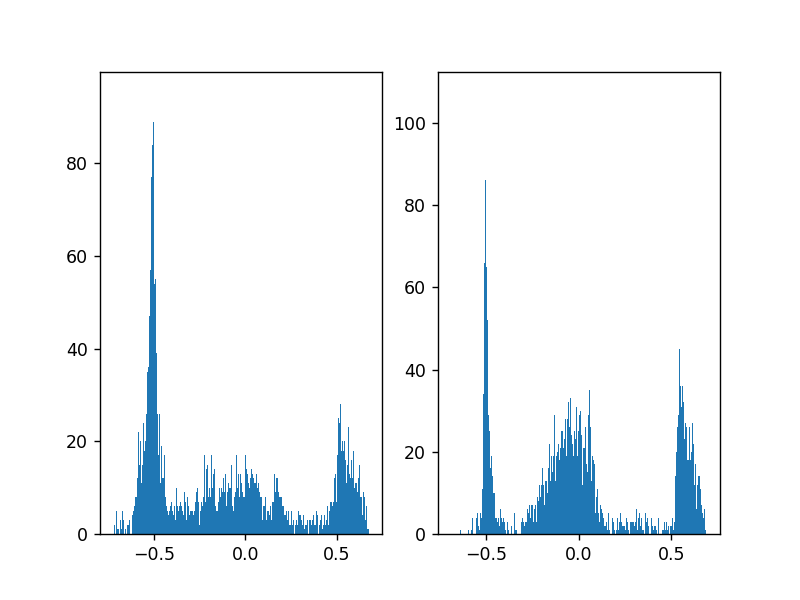

<IPython.core.display.Javascript object>


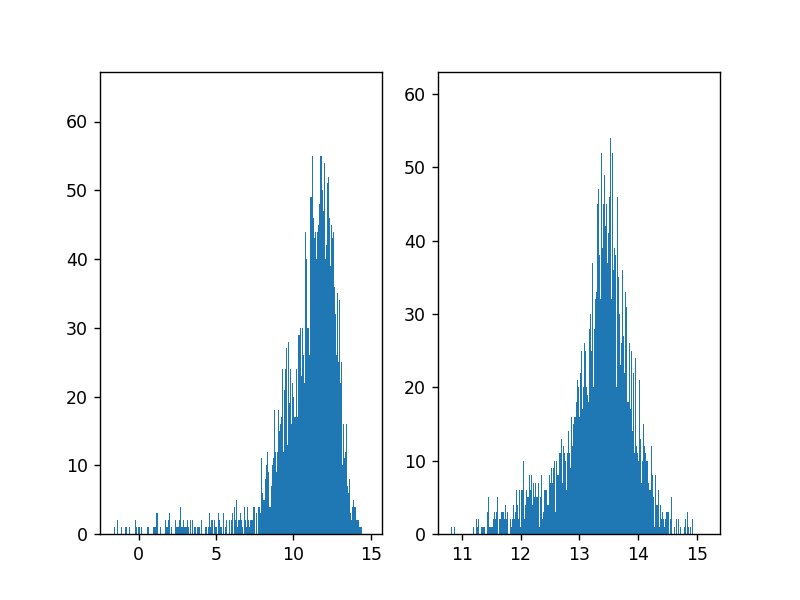

<IPython.core.display.Javascript object>


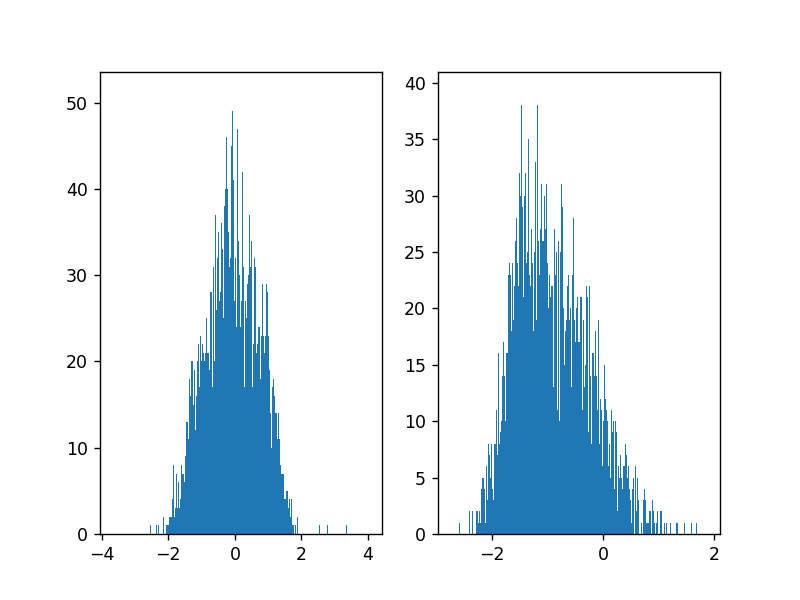

<IPython.core.display.Javascript object>


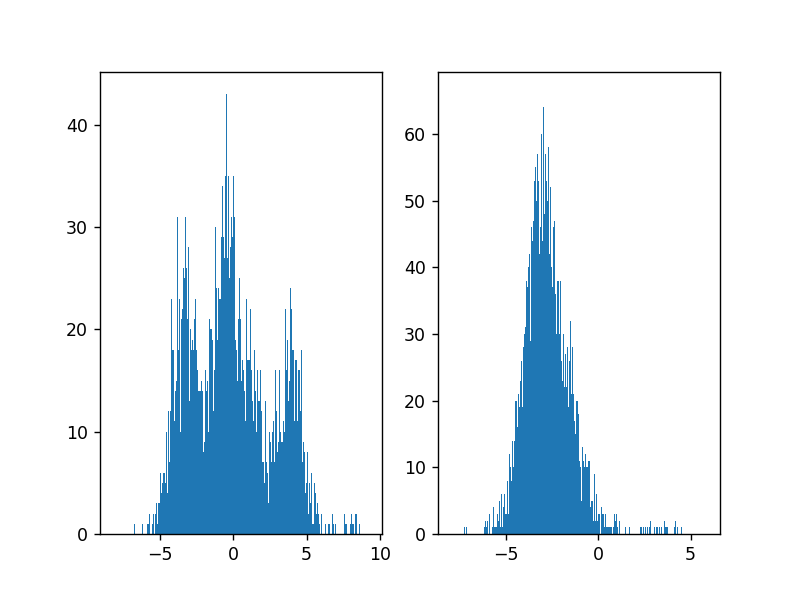

<IPython.core.display.Javascript object>


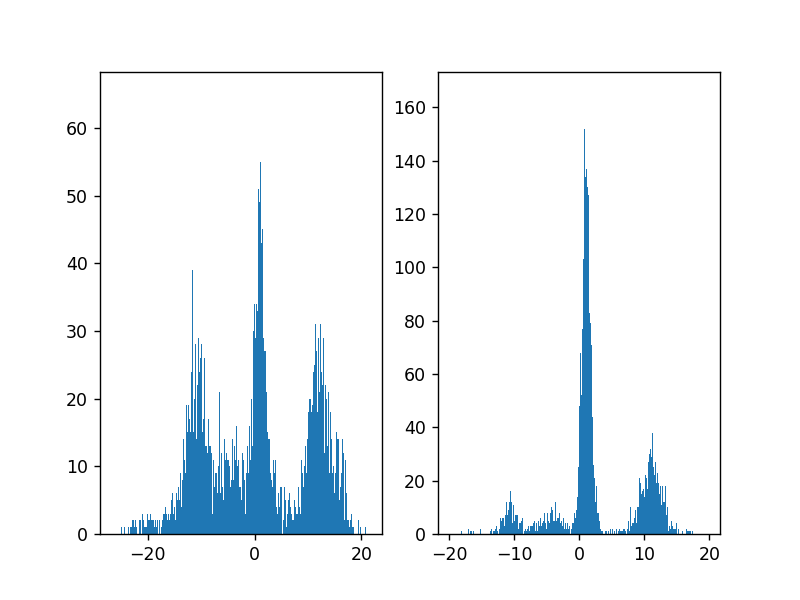

<IPython.core.display.Javascript object>


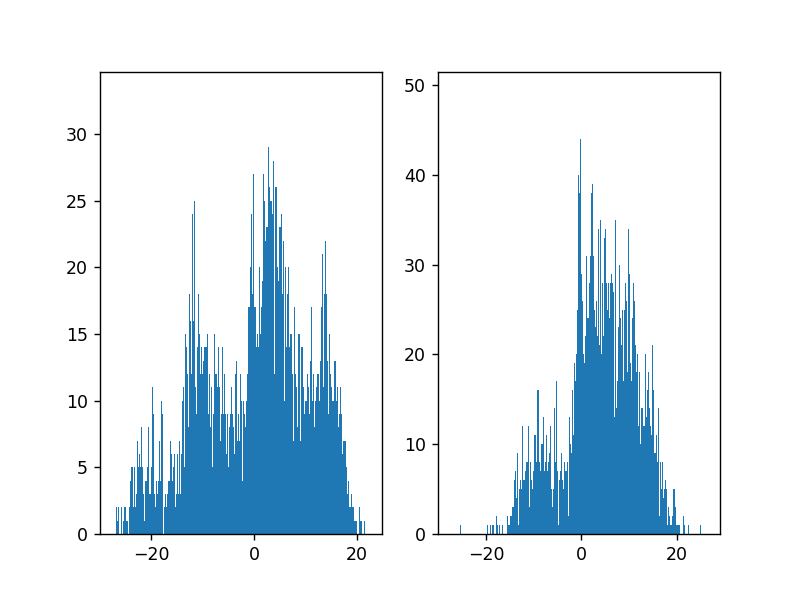

<IPython.core.display.Javascript object>


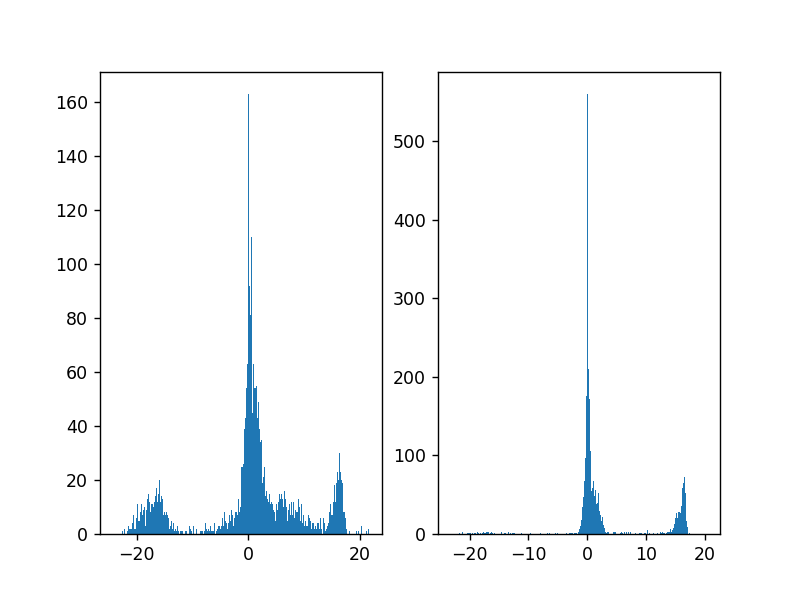

<IPython.core.display.Javascript object>


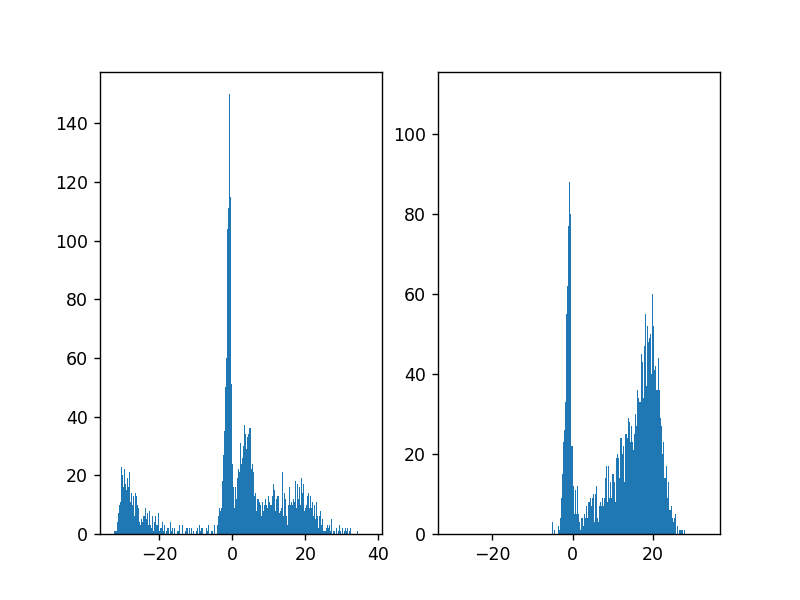

<IPython.core.display.Javascript object>


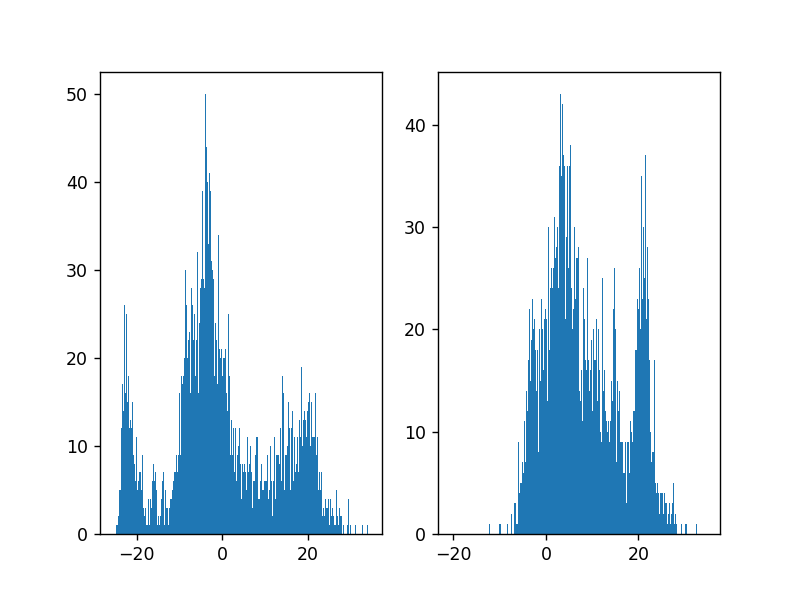

<IPython.core.display.Javascript object>


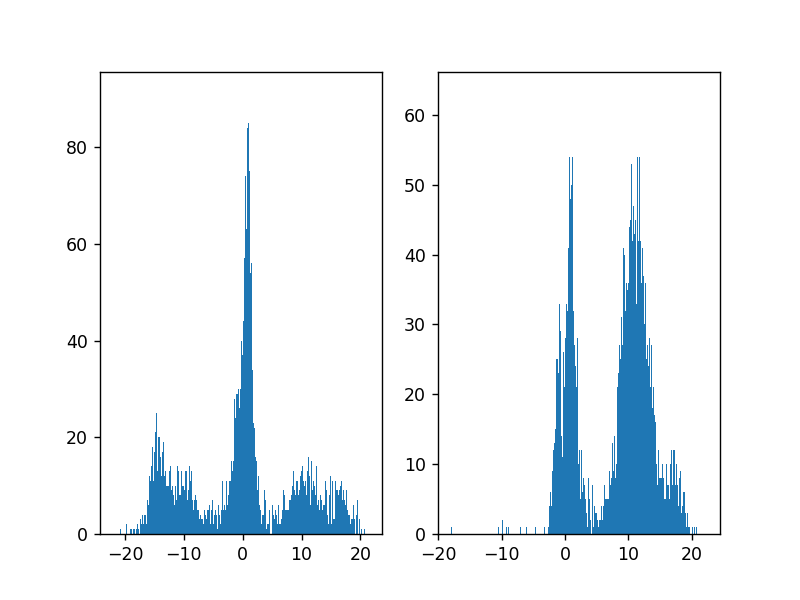

In [10]:
replay_buffer.obs1_buf
replay_buffer.acts_buf
replay_buffer.rews_buf
replay_buffer.obs2_buf

top = 10000
# plt.plot(np.arange(top), replay_buffer.rews_buf_sorted[:top])
# plt.scatter(replay_buffer.obs1_buf_sorted[:top][0],replay_buffer.obs1_buf_sorted[:top][1])
hist_num = 1000
for i in range(obs_dim):
    plt.figure()
    ax1=plt.subplot(1, 2, 1)
    _ = ax1.hist(replay_buffer.obs1_buf[-top:][:,i], hist_num)
    ax2=plt.subplot(1, 2, 2)
    _ = ax2.hist(replay_buffer.obs1_buf_sorted[:top][:,i], hist_num)

In [11]:
# experience_df.columns[2:2+obs_dim]
# experience_df.columns[2+obs_dim:2+obs_dim+act_dim]
# experience_df.columns[2+obs_dim+act_dim:2+obs_dim+act_dim+1]
# experience_df.columns[2+obs_dim+act_dim+1:2+obs_dim+act_dim+1+obs_dim]
# experience_df.columns[2+obs_dim+act_dim+1+obs_dim:2+obs_dim+act_dim+1+obs_dim+1]
# print(replay_buffer.obs1_buf.shape)
# print(replay_buffer.acts_buf.shape)
# print(replay_buffer.rews_buf.shape)
# print(replay_buffer.obs2_buf.shape)
# print(replay_buffer.done_buf.shape)
replay_buffer.obs1_buf[[1,2,3]].shape

(3, 17)

<IPython.core.display.Javascript object>


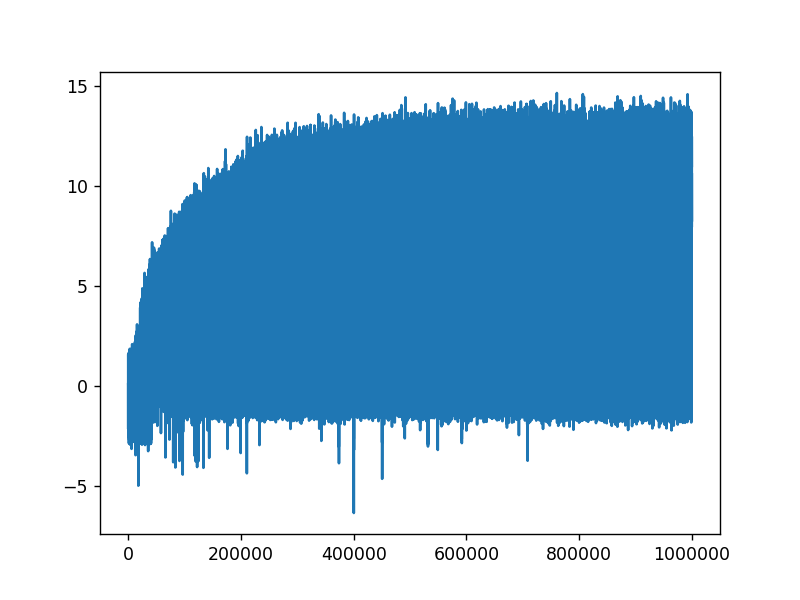

In [12]:
plt.figure()
plt.plot(np.arange(len(replay_buffer.rews_buf)),replay_buffer.rews_buf)

In [13]:
# from sklearn.neighbors import KDTree
# X = replay_buffer.obs1_buf
# kdt = KDTree(X, leaf_size=30, metric='euclidean')

# from sklearn.neighbors import NearestNeighbors
# X = replay_buffer.obs1_buf
# nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)
# nbrs.kneighbors_graph(X).toarray()

## Create Actor-Critic

In [24]:
tf.reset_default_graph()
actor_critic=core.mlp_actor_critic
tf.set_random_seed(seed)
np.random.seed(seed)

def env_fn():
    return gym.make('HalfCheetah-v2')
env, test_env = env_fn(), env_fn()
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]

# Action limit for clamping: critically, assumes all dimensions share the same bound!
act_limit = env.action_space.high[0]

# Share information about action space with policy architecture
ac_kwargs['action_space'] = env.action_space

# Create policy
# Inputs to computation graph
x_ph, a_ph, x2_ph, r_ph, d_ph = core.placeholders(obs_dim, act_dim, obs_dim, None, None)

# Main outputs from computation graph
with tf.variable_scope('main'):
    pi, pi_reg, pi_dropout_mask_generator, pi_dropout_mask_phs,\
    q, q_reg, q_dropout_mask_generator, q_dropout_mask_phs,\
    q_pi, q_pi_reg = actor_critic(x_ph, a_ph, **ac_kwargs, dropout_rate=dropout_rate)
    
    obs_set_size = 10
    track_obs_set_unc_frequency = 100
    pi_unc_module = DropoutUncertaintyModule(act_dim, obs_dim, n_post_action,
                                             obs_set_size, track_obs_set_unc_frequency,
                                             pi, x_ph, pi_dropout_mask_phs, pi_dropout_mask_generator,
                                             logger_kwargs, logger_name='dropout_relearn')

Logging data to c:\users\pc-admin\github repos\spinningup\data\2019-04-12_ud3_test_experience_saving\2019-04-12_11-05-56-ud3_test_experience_saving_s3\dropout_relearn_uncertainty.txt
Logging data to c:\users\pc-admin\github repos\spinningup\data\2019-04-12_ud3_test_experience_saving\2019-04-12_11-05-56-ud3_test_experience_saving_s3\dropout_relearn_sample_observation.txt


In [25]:
# Bellman backup for Q functions, using Clipped Double-Q targets

# TD3 losses
pi_loss = tf.reduce_mean((pi-a_ph)**2)

# Separate train ops for pi, q
pi_optimizer = tf.train.AdamOptimizer(learning_rate=pi_lr)
train_pi_op = pi_optimizer.minimize(pi_loss, var_list=get_vars('main/pi'))


### Relearn Policy

In [26]:
def get_action_test(o):
    """Get deterministic action without noise and dropout."""
    feed_dictionary = {x_ph: o.reshape(1, -1)}
    for mask_i in range(len(pi_dropout_mask_phs)):
        feed_dictionary[pi_dropout_mask_phs[mask_i]] = np.ones(pi_dropout_mask_phs[mask_i].shape.as_list())
    a = sess.run(pi, feed_dict=feed_dictionary)[0]
    return np.clip(a, -act_limit, act_limit)

def test_agent(n=10,max_ep_len=1000):
    for j in range(n):
        o, r, d, ep_ret, ep_len = test_env.reset(), 0, False, 0, 0
        while not(d or (ep_len == max_ep_len)):
            # Take deterministic actions at test time (noise_scale=0)
            o, r, d, _ = test_env.step(get_action_test(o))
            ep_ret += r
            ep_len += 1
        print('    TestEpRet: {}, TestEpLen:{}'.format(ep_ret, ep_len))

In [27]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [28]:
total_steps = steps_per_epoch * epochs
feed_dict_train = {}
# 
for mask_i in range(len(pi_dropout_mask_phs)):
    feed_dict_train[pi_dropout_mask_phs[mask_i]] = np.ones(pi_dropout_mask_phs[mask_i].shape.as_list())
for mask_i in range(len(q_dropout_mask_phs)):
    feed_dict_train[q_dropout_mask_phs[mask_i]] = np.ones(q_dropout_mask_phs[mask_i].shape.as_list())

    
for t in range(total_steps):
    if pi_unc_module.obs_set_is_empty:
        pi_unc_module.sample_obs_set_from_replay_buffer(replay_buffer)
    pi_unc_module.calculate_obs_set_uncertainty(sess, t // steps_per_epoch, t)
    
    batch = replay_buffer.sample_batch(batch_size)
    feed_dict_train[x_ph] = batch['obs1']
    feed_dict_train[x2_ph] = batch['obs2']
    feed_dict_train[a_ph] = batch['acts']
    feed_dict_train[r_ph] = batch['rews']
    feed_dict_train[d_ph] = batch['done']
       
    
    # Delayed policy update
    outs_pi = sess.run([pi_loss, train_pi_op], feed_dict_train)
       
    # End of epoch wrap-up
    if t > 0 and t % steps_per_epoch == 0:
        epoch = t // steps_per_epoch

        # Test the performance of the deterministic version of the agent.
        print('Epoch {}...'.format(epoch))
        print('    LossPi={}'.format(outs_pi[0]))
        
        test_agent(n=1, max_ep_len=max_ep_len)


Epoch 1...
    LossPi=0.12521985173225403
    TestEpRet: 8296.756430667692, TestEpLen:1000
Epoch 2...
    LossPi=0.1337045431137085
    TestEpRet: 9477.871119047019, TestEpLen:1000
Epoch 3...
    LossPi=0.12653106451034546
    TestEpRet: -350.1257471614684, TestEpLen:1000
Epoch 4...
    LossPi=0.10305090248584747
    TestEpRet: 9586.31084705137, TestEpLen:1000
Epoch 5...
    LossPi=0.12427963316440582
    TestEpRet: 9260.479566231628, TestEpLen:1000
Epoch 6...
    LossPi=0.126491978764534
    TestEpRet: 9867.268214042457, TestEpLen:1000
Epoch 7...
    LossPi=0.09928441047668457
    TestEpRet: 9813.730335725466, TestEpLen:1000
Epoch 8...
    LossPi=0.10877832025289536
    TestEpRet: 9796.668567313676, TestEpLen:1000
Epoch 9...
    LossPi=0.08849748969078064
    TestEpRet: 10032.736034494656, TestEpLen:1000
Epoch 10...
    LossPi=0.08681605011224747
    TestEpRet: 10278.001768773362, TestEpLen:1000
Epoch 11...
    LossPi=0.11011650413274765
    TestEpRet: 9904.841262805887, TestEpLen:100

    LossPi=0.1046411544084549
    TestEpRet: 9962.394156803583, TestEpLen:1000
Epoch 178...
    LossPi=0.11052840948104858
    TestEpRet: 10432.518990378197, TestEpLen:1000
Epoch 179...
    LossPi=0.10708625614643097
    TestEpRet: 10523.771374324555, TestEpLen:1000
Epoch 180...
    LossPi=0.0767904669046402
    TestEpRet: 10466.942497622347, TestEpLen:1000
Epoch 181...
    LossPi=0.10666726529598236
    TestEpRet: -73.59974796224176, TestEpLen:1000
Epoch 182...
    LossPi=0.1449415683746338
    TestEpRet: 10006.073008218149, TestEpLen:1000
Epoch 183...
    LossPi=0.07809115201234818
    TestEpRet: 10483.403405407376, TestEpLen:1000
Epoch 184...
    LossPi=0.09241066128015518
    TestEpRet: 10557.830982669533, TestEpLen:1000
Epoch 185...
    LossPi=0.11657480895519257
    TestEpRet: 10675.885383476465, TestEpLen:1000
Epoch 186...
    LossPi=0.06928998231887817
    TestEpRet: 10449.579716251668, TestEpLen:1000
Epoch 187...
    LossPi=0.12311210483312607
    TestEpRet: 10554.488902341462

In [37]:
total_steps = steps_per_epoch * epochs
feed_dict_train = {}
# 
for mask_i in range(len(pi_dropout_mask_phs)):
    feed_dict_train[pi_dropout_mask_phs[mask_i]] = np.ones(pi_dropout_mask_phs[mask_i].shape.as_list())
for mask_i in range(len(q_dropout_mask_phs)):
    feed_dict_train[q_dropout_mask_phs[mask_i]] = np.ones(q_dropout_mask_phs[mask_i].shape.as_list())

    
for t in range(total_steps):
    batch = replay_buffer.sample_batch(batch_size, start=950000, end=None)
    feed_dict_train[x_ph] = batch['obs1']
    feed_dict_train[x2_ph] = batch['obs2']
    feed_dict_train[a_ph] = batch['acts']
    feed_dict_train[r_ph] = batch['rews']
    feed_dict_train[d_ph] = batch['done']
       
    
    # Delayed policy update
    outs_pi = sess.run([pi_loss, train_pi_op], feed_dict_train)
       
    # End of epoch wrap-up
    if t > 0 and t % steps_per_epoch == 0:
        epoch = t // steps_per_epoch

        # Test the performance of the deterministic version of the agent.
        print('Epoch {}...'.format(epoch))
        print('    LossPi={}'.format(outs_pi[0]))
        
        test_agent(n=1, max_ep_len=max_ep_len)


Epoch 1...
    LossPi=0.09648886322975159
    TestEpRet: 8973.26599621269, TestEpLen:1000
Epoch 2...
    LossPi=0.09858307242393494
    TestEpRet: 9657.146047737993, TestEpLen:1000
Epoch 3...
    LossPi=0.0473288930952549
    TestEpRet: 9929.57084958641, TestEpLen:1000
Epoch 4...
    LossPi=0.05866045132279396
    TestEpRet: 10601.02353210374, TestEpLen:1000
Epoch 5...
    LossPi=0.043345123529434204
    TestEpRet: 9574.527609740566, TestEpLen:1000
Epoch 6...
    LossPi=0.03790316358208656
    TestEpRet: 10573.603980926044, TestEpLen:1000
Epoch 7...
    LossPi=0.0423535592854023
    TestEpRet: 10530.67103566041, TestEpLen:1000
Epoch 8...
    LossPi=0.02253243699669838
    TestEpRet: 9879.633743963514, TestEpLen:1000
Epoch 9...
    LossPi=0.04477035254240036
    TestEpRet: 10596.19577549225, TestEpLen:1000
Epoch 10...
    LossPi=0.040738094598054886
    TestEpRet: 9552.868387931187, TestEpLen:1000
Epoch 11...
    LossPi=0.031799692660570145
    TestEpRet: 10728.568214947338, TestEpLen:1

KeyboardInterrupt: 

In [33]:
total_steps = steps_per_epoch * epochs
feed_dict_train = {}
# 
for mask_i in range(len(pi_dropout_mask_phs)):
    feed_dict_train[pi_dropout_mask_phs[mask_i]] = np.ones(pi_dropout_mask_phs[mask_i].shape.as_list())
for mask_i in range(len(q_dropout_mask_phs)):
    feed_dict_train[q_dropout_mask_phs[mask_i]] = np.ones(q_dropout_mask_phs[mask_i].shape.as_list())

    
for t in range(total_steps):
    batch = replay_buffer.sample_batch_sorted(batch_size, top=100000)
    feed_dict_train[x_ph] = batch['obs1']
    feed_dict_train[x2_ph] = batch['obs2']
    feed_dict_train[a_ph] = batch['acts']
    feed_dict_train[r_ph] = batch['rews']
    feed_dict_train[d_ph] = batch['done']
    
    # Delayed policy update
    outs_pi = sess.run([pi_loss, train_pi_op], feed_dict_train)
       
    # End of epoch wrap-up
    if t > 0 and t % steps_per_epoch == 0:
        epoch = t // steps_per_epoch

        # Test the performance of the deterministic version of the agent.
        print('Epoch {}...'.format(epoch))
        print('    LossPi={}'.format(outs_pi[0]))
        
        test_agent(n=1, max_ep_len=max_ep_len)


Epoch 1...
    LossPi=0.05248773470520973
    TestEpRet: -141.6131219539447, TestEpLen:1000
Epoch 2...
    LossPi=0.06938529014587402
    TestEpRet: 1284.5524764332085, TestEpLen:1000
Epoch 3...
    LossPi=0.06838823854923248
    TestEpRet: 356.3608527478393, TestEpLen:1000
Epoch 4...
    LossPi=0.05118231475353241
    TestEpRet: -524.649170801865, TestEpLen:1000
Epoch 5...
    LossPi=0.05346693843603134
    TestEpRet: -425.9593161133734, TestEpLen:1000
Epoch 6...
    LossPi=0.04425276815891266
    TestEpRet: 400.42471338296633, TestEpLen:1000
Epoch 7...
    LossPi=0.039861906319856644
    TestEpRet: -52.012481742346544, TestEpLen:1000
Epoch 8...
    LossPi=0.04704698920249939
    TestEpRet: -534.3458136090289, TestEpLen:1000
Epoch 9...
    LossPi=0.04714686796069145
    TestEpRet: -222.77051961754287, TestEpLen:1000
Epoch 10...
    LossPi=0.04511496052145958
    TestEpRet: 314.21784294955273, TestEpLen:1000
Epoch 11...
    LossPi=0.042811885476112366
    TestEpRet: -345.52505036474184

Epoch 89...
    LossPi=0.04858836904168129
    TestEpRet: -154.38605630690012, TestEpLen:1000
Epoch 90...
    LossPi=0.032039400190114975
    TestEpRet: -411.5741436500353, TestEpLen:1000
Epoch 91...
    LossPi=0.040269434452056885
    TestEpRet: -368.57613312134794, TestEpLen:1000
Epoch 92...
    LossPi=0.030539626255631447
    TestEpRet: -245.78501886597977, TestEpLen:1000
Epoch 93...
    LossPi=0.02570331282913685
    TestEpRet: -527.2696113116091, TestEpLen:1000
Epoch 94...
    LossPi=0.023215748369693756
    TestEpRet: -216.12014961563443, TestEpLen:1000
Epoch 95...
    LossPi=0.03524428606033325
    TestEpRet: -592.6053901889213, TestEpLen:1000
Epoch 96...
    LossPi=0.035378336906433105
    TestEpRet: -406.2980996023212, TestEpLen:1000
Epoch 97...
    LossPi=0.035076454281806946
    TestEpRet: -332.8238333514428, TestEpLen:1000
Epoch 98...
    LossPi=0.030920403078198433
    TestEpRet: -247.32181708647656, TestEpLen:1000
Epoch 99...
    LossPi=0.047380492091178894
    TestEpRet:

KeyboardInterrupt: 

In [27]:
total_steps = steps_per_epoch * epochs
feed_dict_train = {}
# 
for mask_i in range(len(pi_dropout_mask_phs)):
    feed_dict_train[pi_dropout_mask_phs[mask_i]] = np.ones(pi_dropout_mask_phs[mask_i].shape.as_list())
for mask_i in range(len(q_dropout_mask_phs)):
    feed_dict_train[q_dropout_mask_phs[mask_i]] = np.ones(q_dropout_mask_phs[mask_i].shape.as_list())

    
for t in range(total_steps):
    batch = replay_buffer.sample_batch_sorted(batch_size, top=100000)
    feed_dict_train[x_ph] = batch['obs1']
    feed_dict_train[x2_ph] = batch['obs2']
    feed_dict_train[a_ph] = batch['acts']
    feed_dict_train[r_ph] = batch['rews']
    feed_dict_train[d_ph] = batch['done']
       
    
    # Delayed policy update
    outs_pi = sess.run([pi_loss, train_pi_op], feed_dict_train)
       
    # End of epoch wrap-up
    if t > 0 and t % steps_per_epoch == 0:
        epoch = t // steps_per_epoch

        # Test the performance of the deterministic version of the agent.
        print('Epoch {}...'.format(epoch))
        print('    LossPi={}'.format(outs_pi[0]))
        
        test_agent(n=1, max_ep_len=max_ep_len)


Epoch 1...
    LossPi=0.19313493371009827
    TestEpRet: 8956.157229733544, TestEpLen:1000
Epoch 2...
    LossPi=0.12564827501773834
    TestEpRet: 9300.768039998584, TestEpLen:1000
Epoch 3...
    LossPi=0.07900027185678482
    TestEpRet: 8874.55758676145, TestEpLen:1000
Epoch 4...
    LossPi=0.09124092757701874
    TestEpRet: 10135.699690570493, TestEpLen:1000
Epoch 5...
    LossPi=0.10304290801286697
    TestEpRet: 8961.401432200848, TestEpLen:1000
Epoch 6...
    LossPi=0.09026489406824112
    TestEpRet: 9350.916347347144, TestEpLen:1000
Epoch 7...
    LossPi=0.16253122687339783
    TestEpRet: 1957.611770387188, TestEpLen:1000
Epoch 8...
    LossPi=0.11983275413513184
    TestEpRet: 10037.177142564271, TestEpLen:1000
Epoch 9...
    LossPi=0.11732407659292221
    TestEpRet: 9577.497814147067, TestEpLen:1000
Epoch 10...
    LossPi=0.13846054673194885
    TestEpRet: 7524.4614768680985, TestEpLen:1000
Epoch 11...
    LossPi=0.09502245485782623
    TestEpRet: 9592.93295812327, TestEpLen:1

KeyboardInterrupt: 

In [35]:
total_steps = steps_per_epoch * epochs
feed_dict_train = {}
# 
for mask_i in range(len(pi_dropout_mask_phs)):
    feed_dict_train[pi_dropout_mask_phs[mask_i]] = np.ones(pi_dropout_mask_phs[mask_i].shape.as_list())
for mask_i in range(len(q_dropout_mask_phs)):
    feed_dict_train[q_dropout_mask_phs[mask_i]] = np.ones(q_dropout_mask_phs[mask_i].shape.as_list())

    
for t in range(total_steps):
    batch = replay_buffer.sample_batch(batch_size, start=900000, end=None)
    feed_dict_train[x_ph] = batch['obs1']
    feed_dict_train[x2_ph] = batch['obs2']
    feed_dict_train[a_ph] = batch['acts']
    feed_dict_train[r_ph] = batch['rews']
    feed_dict_train[d_ph] = batch['done']
       
    
    # Delayed policy update
    outs_pi = sess.run([pi_loss, train_pi_op], feed_dict_train)
       
    # End of epoch wrap-up
    if t > 0 and t % steps_per_epoch == 0:
        epoch = t // steps_per_epoch

        # Test the performance of the deterministic version of the agent.
        print('Epoch {}...'.format(epoch))
        print('    LossPi={}'.format(outs_pi[0]))
        
        test_agent(n=1, max_ep_len=max_ep_len)


Epoch 1...
    LossPi=0.07587895542383194
    TestEpRet: 9271.499244713043, TestEpLen:1000
Epoch 2...
    LossPi=0.06374859064817429
    TestEpRet: 9672.089226275728, TestEpLen:1000
Epoch 3...
    LossPi=0.052153293043375015
    TestEpRet: 10108.074593072699, TestEpLen:1000
Epoch 4...
    LossPi=0.02546241320669651
    TestEpRet: 10658.20260057657, TestEpLen:1000
Epoch 5...
    LossPi=0.06535030901432037
    TestEpRet: 10293.467969397252, TestEpLen:1000
Epoch 6...
    LossPi=0.06577658653259277
    TestEpRet: 10829.06058472754, TestEpLen:1000
Epoch 7...
    LossPi=0.060186970978975296
    TestEpRet: 10702.202125937565, TestEpLen:1000
Epoch 8...
    LossPi=0.04219681769609451
    TestEpRet: 10366.304924022535, TestEpLen:1000
Epoch 9...
    LossPi=0.03950684890151024
    TestEpRet: 10578.890365474077, TestEpLen:1000
Epoch 10...
    LossPi=0.06009896472096443
    TestEpRet: 10398.890929845293, TestEpLen:1000
Epoch 11...
    LossPi=0.04958103969693184
    TestEpRet: 10403.115424044923, Tes

KeyboardInterrupt: 

In [26]:
total_steps = steps_per_epoch * epochs
feed_dict_train = {}
# 
for mask_i in range(len(pi_dropout_mask_phs)):
    feed_dict_train[pi_dropout_mask_phs[mask_i]] = np.ones(pi_dropout_mask_phs[mask_i].shape.as_list())
for mask_i in range(len(q_dropout_mask_phs)):
    feed_dict_train[q_dropout_mask_phs[mask_i]] = np.ones(q_dropout_mask_phs[mask_i].shape.as_list())

    
for t in range(total_steps):
    batch = replay_buffer.sample_batch(batch_size, start=400000, end=None)
    feed_dict_train[x_ph] = batch['obs1']
    feed_dict_train[x2_ph] = batch['obs2']
    feed_dict_train[a_ph] = batch['acts']
    feed_dict_train[r_ph] = batch['rews']
    feed_dict_train[d_ph] = batch['done']
       
    
    # Delayed policy update
    outs_pi = sess.run([pi_loss, train_pi_op], feed_dict_train)
       
    # End of epoch wrap-up
    if t > 0 and t % steps_per_epoch == 0:
        epoch = t // steps_per_epoch

        # Test the performance of the deterministic version of the agent.
        print('Epoch {}...'.format(epoch))
        print('    LossPi={}'.format(outs_pi[0]))
        
        test_agent(n=1, max_ep_len=max_ep_len)


Epoch 1...
    LossPi=0.06462617218494415
    TestEpRet: 9169.772220502598, TestEpLen:1000
Epoch 2...
    LossPi=0.09921544790267944
    TestEpRet: 10161.554494687442, TestEpLen:1000
Epoch 3...
    LossPi=0.05338633060455322
    TestEpRet: 9420.704632756422, TestEpLen:1000
Epoch 4...
    LossPi=0.09169669449329376
    TestEpRet: 10201.008381689588, TestEpLen:1000
Epoch 5...
    LossPi=0.10286276787519455
    TestEpRet: 10021.403687094553, TestEpLen:1000
Epoch 6...
    LossPi=0.09600551426410675
    TestEpRet: 9874.75913472287, TestEpLen:1000
Epoch 7...
    LossPi=0.05239446461200714
    TestEpRet: 10320.707864271366, TestEpLen:1000
Epoch 8...
    LossPi=0.06973278522491455
    TestEpRet: 10156.686025980523, TestEpLen:1000
Epoch 9...
    LossPi=0.05828104540705681
    TestEpRet: 10171.191880184046, TestEpLen:1000
Epoch 10...
    LossPi=0.08417225629091263
    TestEpRet: 10586.384636992992, TestEpLen:1000
Epoch 11...
    LossPi=0.05006864666938782
    TestEpRet: 10433.595591603871, TestE

KeyboardInterrupt: 

### Show trajectory of states

In [16]:
from sklearn.manifold import TSNE
tsne_2d = TSNE(n_components=2, random_state=0, verbose=1)

X_2d = tsne_2d.fit_transform(replay_buffer.obs1_buf[:40000])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 40000 samples in 0.044s...
[t-SNE] Computed neighbors for 40000 samples in 14.347s...
[t-SNE] Computed conditional probabilities for sample 1000 / 40000
[t-SNE] Computed conditional probabilities for sample 2000 / 40000
[t-SNE] Computed conditional probabilities for sample 3000 / 40000
[t-SNE] Computed conditional probabilities for sample 4000 / 40000
[t-SNE] Computed conditional probabilities for sample 5000 / 40000
[t-SNE] Computed conditional probabilities for sample 6000 / 40000
[t-SNE] Computed conditional probabilities for sample 7000 / 40000
[t-SNE] Computed conditional probabilities for sample 8000 / 40000
[t-SNE] Computed conditional probabilities for sample 9000 / 40000
[t-SNE] Computed conditional probabilities for sample 10000 / 40000
[t-SNE] Computed conditional probabilities for sample 11000 / 40000
[t-SNE] Computed conditional probabilities for sample 12000 / 40000
[t-SNE] Computed conditional probabilities for sa

<IPython.core.display.Javascript object>


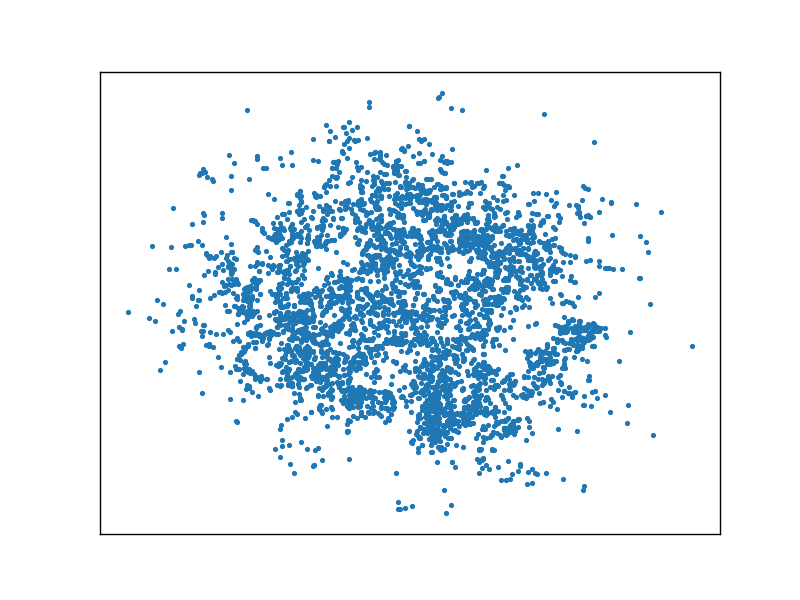

<IPython.core.display.Javascript object>


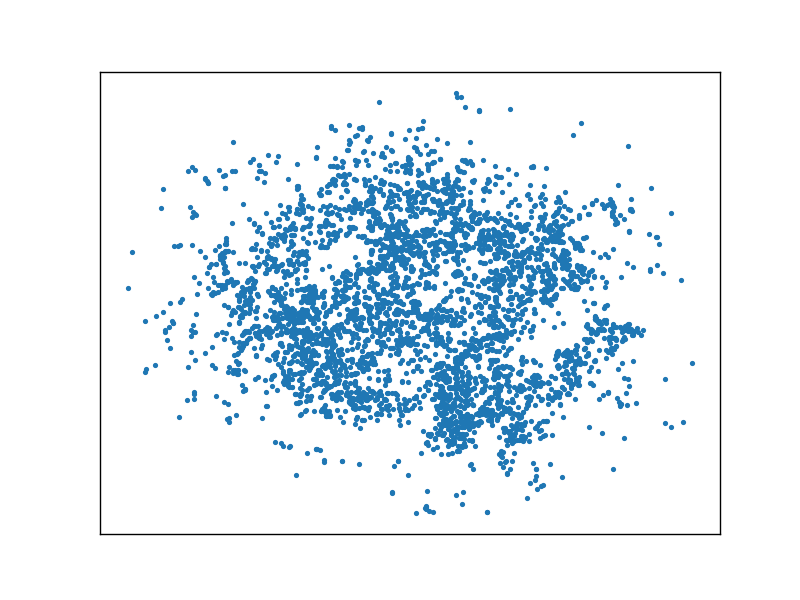

<IPython.core.display.Javascript object>


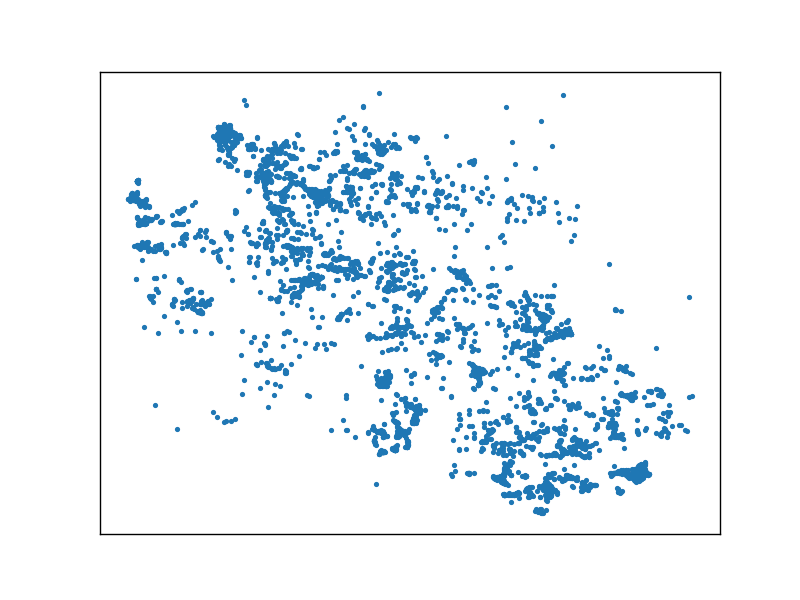

<IPython.core.display.Javascript object>


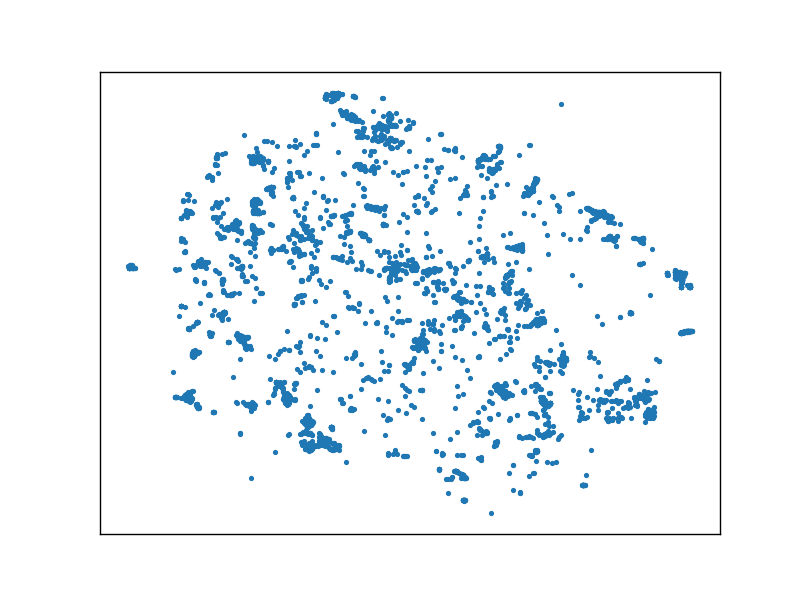

<IPython.core.display.Javascript object>


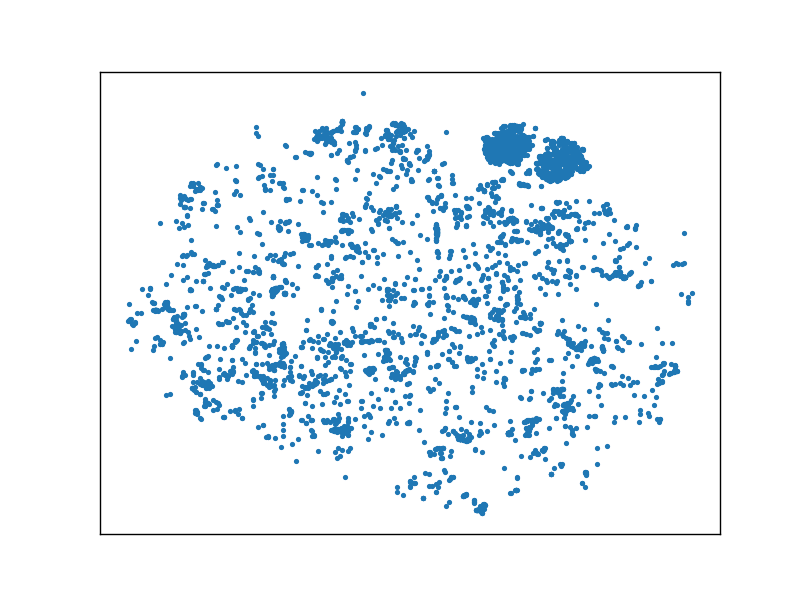

<IPython.core.display.Javascript object>


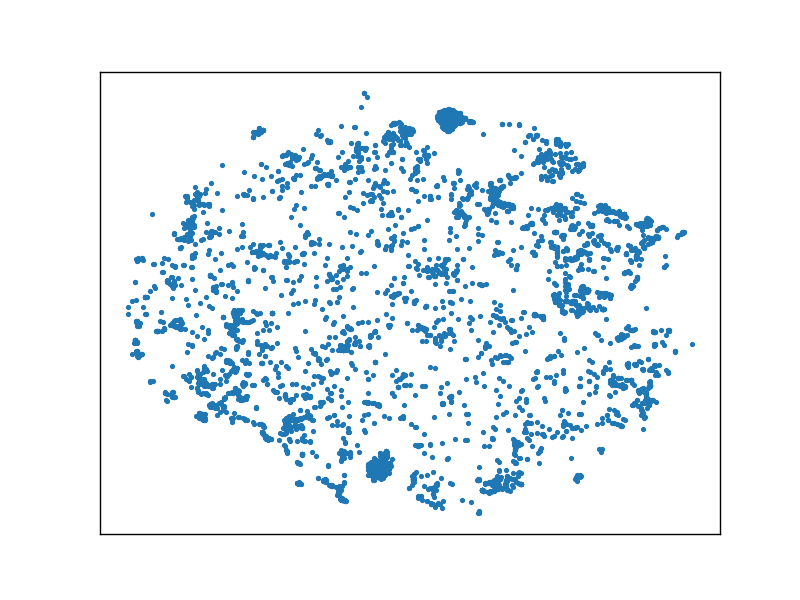

<IPython.core.display.Javascript object>


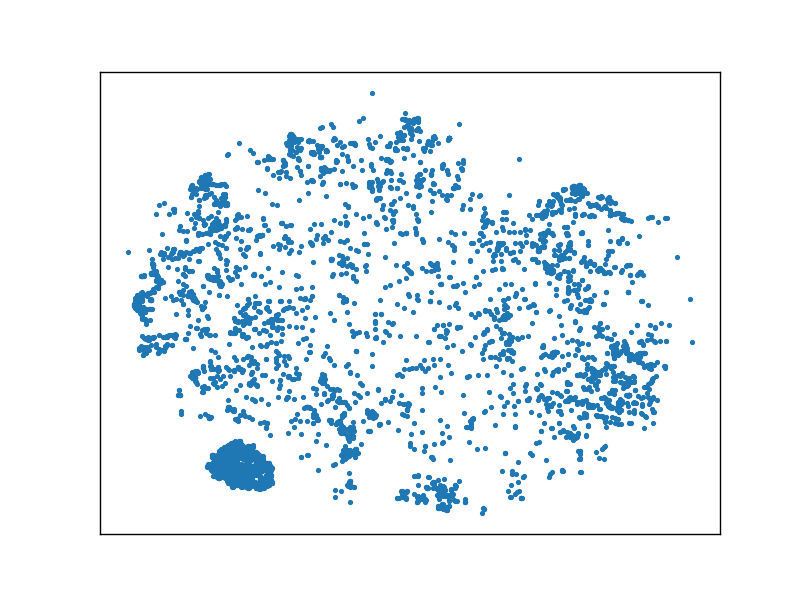

<IPython.core.display.Javascript object>


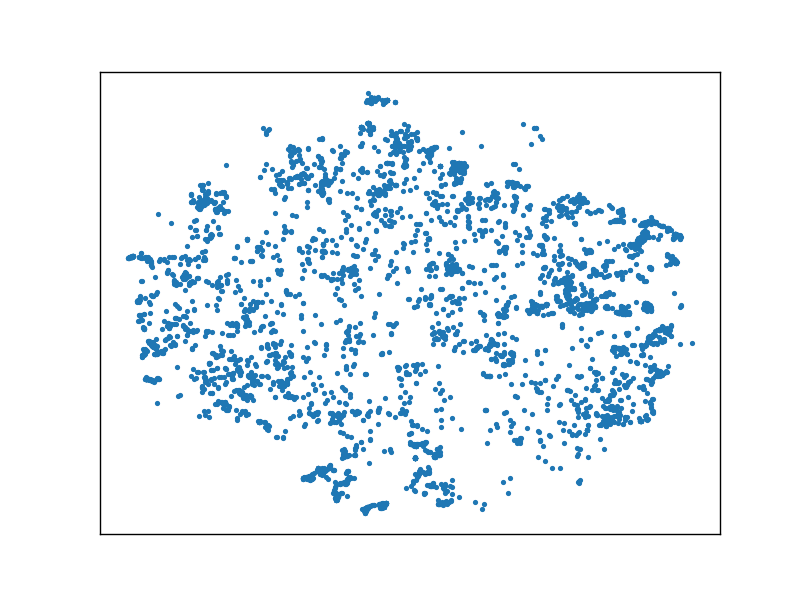

In [17]:
# plt.figure()
# plt.scatter(X_2d[:,0], X_2d[:,1])
ep_len = 5000
for ep in range(8):
    plt.figure()
    plt.scatter(X_2d[ep*ep_len:(ep+1)*ep_len,0], X_2d[ep*ep_len:(ep+1)*ep_len, 1],s=4)
    
    plt.xticks([])
    plt.yticks([])
    plt.show()
# plt.legend(['Day 1', 'Day 2', 'Day 3', 'Day 4'])
# plt.title('t-SNE action embedding vectors of SARA')
# plt.savefig('./figures/SARA_action_pie_plots/t_SNE_action_embedding_vectors_of_SARA.jpg',
#          dpi=300, bbox_inches='tight', pad_inches=0)